In [32]:
import keras
import random
import pickle
import numpy as np
import scipy.ndimage
import tensorflow as tf
import os
import warnings
from PIL import Image
from keras import metrics
from random import shuffle
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD
from keras.layers import  Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate

In [33]:
warnings.filterwarnings('ignore')

In [34]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath="s2-unet-bin-iou.h5", monitor='val_mean_iou', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', factor=0.05, patience=4, mode='max')
    early = keras.callbacks.EarlyStopping(monitor='val_mean_iou', min_delta=1e-4, patience=10, mode='max')
    csv = keras.callbacks.CSVLogger('s2-unet-bin-iou.csv', separator=',')
    callbacks = [checkpointer, reduce, early, csv]
    return callbacks

In [42]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def iou_ce(y_true,y_pred):
    iou = mean_iou(y_true,y_pred)
    ce = keras.losses.binary_crossentropy(y_true, y_pred)
    return iou+ce

In [43]:
h = 256
w = 256
seed = 1
X_path = '/scratch/mraza/Skin/training_data/'
Y_path = '/scratch/mraza/Skin/training_data/'
X_val_path = '/scratch/mraza/Skin/validation_data/'
Y_val_path = '/scratch/mraza/Skin/validation_data/'
X_test_path = '/scratch/mraza/Skin/test_data/'
Y_test_path = '/scratch/mraza/Skin/test_data/'
batch_size = 32
interpolation = 'bilinear'
x_gen_args = dict(
                    rescale=1./255,
                    rotation_range=0.2,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                 )

y_gen_args = dict(
                    rescale=1./255,
                    rotation_range=0.2,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                 )

image_datagen = ImageDataGenerator(**x_gen_args)
mask_datagen = ImageDataGenerator(**y_gen_args)

image_generator = image_datagen.flow_from_directory(
    X_path,
    target_size=(h, w),
    classes = ['images'],
    batch_size=batch_size,
    class_mode=None,
    #interpolation=interpolation,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    Y_path,
    target_size=(h, w),
    classes = ['masks'],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode=None,
    #interpolation=interpolation,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

image_generator = image_datagen.flow_from_directory(
    X_val_path,
    target_size=(h, w),
    classes = ['images'],
    batch_size=batch_size,
    class_mode=None,
    #interpolation=interpolation,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    Y_val_path,
    target_size=(h, w),
    classes = ['masks'],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode=None,
    #interpolation=interpolation,
    seed=seed)

val_generator=zip(image_generator, mask_generator)

image_generator = image_datagen.flow_from_directory(
    X_test_path,
    target_size=(h, w),
    classes = ['images'],
    batch_size=batch_size,
    class_mode=None,
    #interpolation=interpolation,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    Y_test_path,
    target_size=(h, w),
    classes = ['masks'],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode=None,
    #interpolation=interpolation,
    seed=seed)

test_generator=zip(image_generator, mask_generator)


Found 1894 images belonging to 1 classes.
Found 1894 images belonging to 1 classes.
Found 350 images belonging to 1 classes.
Found 350 images belonging to 1 classes.
Found 350 images belonging to 1 classes.
Found 350 images belonging to 1 classes.


In [44]:
x,y = next(train_generator)

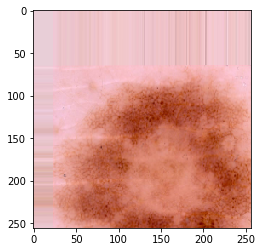

In [45]:
plt.imshow(x[30])

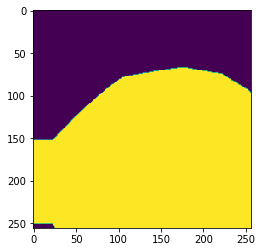

In [46]:
plt.imshow(y[30].reshape(256,256))

In [47]:
def unet(input_layer, features):
    #downsampling 1
    conv1 = Conv2D(features, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(features, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)    #drop 25% to 0 to avoid overfit
 
    #downsampling 2
    conv2 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (pool1)
    conv2 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (conv2)
    pool2 = MaxPooling2D((2, 2)) (conv2)
    pool2 = Dropout(0.3)(pool2)
 
    #downsampling 3
    conv3 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (pool2)
    conv3 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (conv3)
    pool3 = MaxPooling2D((2, 2)) (conv3)   
    pool3 = Dropout(0.4)(pool3)
 
    #downsampling 4
    conv4 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (pool3)
    conv4 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (conv4)
    pool4 = Dropout(0.5)(pool4)
 
    #middle bridge 5
    conv5 = Conv2D(features * 2**4, (3, 3), activation='relu', padding='same') (pool4)
    conv5 = Conv2D(features * 2**4, (3, 3), activation='relu', padding='same') (conv5)
 
    #upsampling 6
    tran6 = Conv2DTranspose(features * 2**3, (2, 2), strides=(2, 2), padding='same') (conv5)
    tran6 = concatenate([tran6, conv4])   #merge tran6 and conv4 layers into 1 layer
    tran6 = Dropout(0.5)(tran6)
    conv6 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (tran6)
    conv6 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (conv6)
 
    #upsampling 7
    tran7 = Conv2DTranspose(features * 2**2, (2, 2), strides=(2, 2), padding='same') (conv6)
    tran7 = concatenate([tran7, conv3])   #merge 2 layers into 1 
    tran7 = Dropout(0.4)(tran7)
    conv7 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (tran7)
    conv7 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (conv7)
 
    #upsampling 8
    tran8 = Conv2DTranspose(features * 2, (2, 2), strides=(2, 2), padding='same') (conv7)
    tran8 = concatenate([tran8, conv2])   #merge 2 layers into 1 
    tran8 = Dropout(0.3)(tran8)
    conv8 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (tran8)
    conv8 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (conv8)
 
    #upsampling 9
    tran9 = Conv2DTranspose(features, (2, 2), strides=(2, 2), padding='same') (conv8)
    tran9 = concatenate([tran9, conv1])   #merge 2 layers into 1 
    tran9 = Dropout(0.25)(tran9)
    conv9 = Conv2D(features, (3, 3), activation='relu', padding='same') (tran9)
    conv9 = Conv2D(features, (3, 3), activation='relu', padding='same') (conv9)
 
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(conv9)

    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
 
    return model

In [48]:
input_layer = Input((w, h, 3))
model = unet(input_layer, 64)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
dropout_33

In [ ]:
model.fit_generator(
            train_generator,
            steps_per_epoch = 1894//batch_size, 
            validation_data=val_generator,
            validation_steps=350//batch_size,
            epochs = 100,
            callbacks = build_callbacks()
            )

Epoch 1/100
 9/59 [===>..........................] - ETA: 19:09 - loss: 0.5154 - mean_iou: 0.3631

In [ ]:
loss, iou = model.evaluate_generator(test_generator,len(test_images)//batch_size)

In [ ]:
print('loss is '+str(loss))
print('iou is '+str(iou))